In [9]:
import tensorflow as tf
import pandas as pd
import math
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [41]:
validation_data_load = pd.read_pickle("data/validationAprilDataEnriched")
test_data_load = pd.read_pickle("data/lateAprilDataEnriched")
march_data_load = pd.read_pickle("data/allMarchEnriched")

In [3]:
#This just gets the columns for the labels and drops the unnecessary datetime info
def cleanData(orig_data, get_minutes = False):
    label_column = "trip_length_seconds"
    if get_minutes:
        label_column = "trip_length_minutes_rounded"
    labels_array = orig_data[label_column].copy().values
    labels = np.reshape(labels_array, (len(labels_array), 1))
    clean_data = orig_data.drop(labels = ["lpep_pickup_datetime", "Lpep_dropoff_datetime", "trip_length_seconds", "trip_length_minutes_rounded"], axis = 1)
    return (clean_data.values, labels)

# For the most part, the sun rise/set data has a value of 0 if the time is note 1.5 hours after sunrise or 1.5 hours before sunset
# I realized the sun rise/set data would be large the further away the time was from the sun rise/sun set, which doesn't match
# the behavior that is 0 most of the time.  Therefore, I decided to take the inverse to switch this up.
# In addition, I wanted to see how the model would perform when doing one hot encoding on the categorical type of data.
# Lastly, I also combined the pickup/dropoff minute/hour to get the minutes into the day the pickup/dropoff was since this
# better represents the time.
def getInverseForSundata(x):
    if x == 0:
        return x
    else:
        return 1/x
    
def oneHotEncodedData(orig_data, get_minutes = False):
    label_column = "trip_length_seconds"
    if get_minutes:
        label_column = "trip_length_minutes_rounded"
    labels_array = orig_data[label_column].copy().values
    labels = np.reshape(labels_array, (len(labels_array), 1))
    clean_data = orig_data.drop(labels = ["lpep_pickup_datetime", "Lpep_dropoff_datetime", "trip_length_seconds", "trip_length_minutes_rounded"], axis = 1)
    clean_data = pd.get_dummies(clean_data, columns = ["pickup_weekday", "dropoff_weekday", "RateCodeID", "VendorID", "Trip_type "])
    clean_data["pickup_minute_ofday"] = clean_data["pickup_minute"] + clean_data["pickup_hour"]*60
    clean_data["dropoff_minute_ofday"] = clean_data["dropoff_minute"] + clean_data["dropoff_hour"]*60
    clean_data["pickup_sunset_inverse"] = clean_data["pickup_sunset"].map(lambda x: getInverseForSundata(x))
    clean_data["pickup_sunrise_inverse"] = clean_data["pickup_sunrise"].map(lambda x: getInverseForSundata(x))
    clean_data["dropoff_sunset_inverse"] = clean_data["dropoff_sunset"].map(lambda x: getInverseForSundata(x))
    clean_data["dropoff_sunrise_inverse"] = clean_data["dropoff_sunrise"].map(lambda x: getInverseForSundata(x))
    clean_data = clean_data.drop(labels = ["pickup_minute", "pickup_hour", "dropoff_minute", "dropoff_hour",
                                           "pickup_sunset", "pickup_sunrise", "dropoff_sunset", "dropoff_sunrise"], axis = 1)
    return (clean_data.values, labels)

## RMSE

Since all of the trips were under 3 hours and I am predicting the duration in minutes (up to around 180 unless the model is bad), I use RMSE as my loss function.  RMSLE is better when I'm predicting the duration in seconds.

## With One-Hot Encoded Data

Note that the below code corresponds to the function named buildNeuralNetAndGetAccuracy2OneHot in the NeuralNetCreateAndSave notebook.  

This neural net used the AdamOptimizer instead of the GradientDescentOptimizer and I gave it more hidden neurons per layer because it was created to read in the one-hot encoded data which had more features.

In [26]:
def readAdamOptimized(data, labels, modelNum = 9500):
    tf.reset_default_graph()
    
    #Only two layers
    batch_size = 300
    iterations = 10000
    
    inputFeatureSize = len(data[0])
    print("There are {} features".format(inputFeatureSize))
    hidden_units1 = 40
    hidden_units2 = 40
    output_size = 1
            
    input_placeholder = tf.placeholder(tf.float32, shape=(None, inputFeatureSize), name = "input_placeholder")
    labels_placeholder = tf.placeholder(tf.float32, shape=(None, 1), name = "labels_placeholder")
    
    #remember that we need W of small random values for gradient descent
    hiddenLayer1W = tf.get_variable("w1", initializer = tf.truncated_normal([inputFeatureSize, hidden_units1], stddev=1.0 / math.sqrt(float(inputFeatureSize))))
    hiddenLayer2W = tf.get_variable("w2", initializer = tf.truncated_normal(shape=(hidden_units1, hidden_units2), stddev=1.0 / math.sqrt(float(inputFeatureSize))))
    outW = tf.get_variable("outW", initializer = tf.truncated_normal(shape=(hidden_units2, output_size), stddev=1.0 / math.sqrt(float(inputFeatureSize))))

    hiddenLayer1b = tf.get_variable("b1", initializer = tf.truncated_normal([hidden_units1], stddev=1.0 / math.sqrt(float(inputFeatureSize))))
    hiddenLayer2b = tf.get_variable("b2", initializer = tf.truncated_normal([hidden_units2], stddev=1.0 / math.sqrt(float(inputFeatureSize))))
    outb = tf.get_variable("outB", initializer = tf.truncated_normal([output_size], stddev=1.0 / math.sqrt(float(inputFeatureSize))))

    hiddenLayer1 = tf.nn.relu(tf.matmul(input_placeholder, hiddenLayer1W) + hiddenLayer1b)
    hiddenLayer2 = tf.nn.relu(tf.matmul(hiddenLayer1, hiddenLayer2W) + hiddenLayer2b)
    p_out = tf.matmul(hiddenLayer2, outW) + outb
        
#     loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(tf.log(tf.add(p_out, tf.ones([len(p_out), 1]))), tf.log(tf.add(a_train, tf.ones([len(a_train), 1])))))))
    loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(labels_placeholder, p_out))))

    # Other optimizers - https://www.tensorflow.org/api_guides/python/train#Optimizers
    optimizer = tf.train.AdamOptimizer()
    
    global_step_counter = tf.get_variable("globalStepVal", initializer = 0, trainable=False)
    train_op = optimizer.minimize(loss, global_step=global_step_counter)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        saver.restore(sess, "C:\\Users\\Brittany\\Dropbox\\School\\CMSC678\\machine-learning\\saved_models\\relu_onehot\\model.ckpnt-{}".format(modelNum))
        
        # Calculate accuracy
        accuracy = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(labels_placeholder, p_out))))
        return accuracy.eval({input_placeholder: data, labels_placeholder: labels})

In [35]:
getMinutes = True
validation_data, v_minutes_labels = oneHotEncodedData(validation_data_load, getMinutes)
test_data, test_minutes_labels = oneHotEncodedData(test_data_load, getMinutes)

In [36]:
modelNums = [7500, 8000, 8500, 9000, 9500]
validation_accuracy = []

for i in modelNums:
    validation_accuracy.append(readAdamOptimized(validation_data, v_minutes_labels, i))
print(validation_accuracy)

There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-7500
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-8000
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-8500
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-9000
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-9500
[1.7517421, 1.9288234, 3.9758191, 2.4698508, 1.8169541]


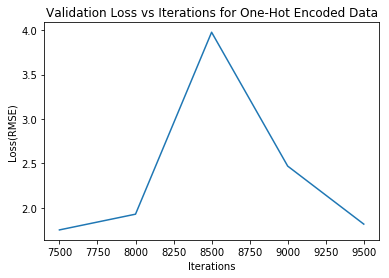

In [37]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_title('Validation Loss vs Iterations for One-Hot Encoded Data')

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss(RMSE)')

ax.plot(modelNums, validation_accuracy)

plt.savefig("paper/reluOneHotAdam.png")
plt.show()

Now, if I'm interpreting the figure above correctly, it appears that the model finds a local minima, which explains the low loss at iteration 7500.  Then, it looks like it jumps out of the local minima as shown by the loss at iteration 8500.  However, it starts to find another local minima for iteration 9500, but the loss at this minima is not as small as that of 7500.  On one hand, I should probably technically use the model saved after iteration 7500 because it is the lowest, but the fact that it jumped out makes me think I should use the model saved after iteration 9500.  There is a possibility the data could be being overfit at iteration 9500, but the fact that the loss isn't lower than that of 7500 indicates it probably isn't.

So, given this, I would use the model saved after iteration 9500 as my model.  However, since the point of this project is to learn, I'm going to cheat a bit and see how the testing data performs on all of the models (but I'm not training using the test data!).

In [39]:
len(test_data)

325922

There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-7500
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-8000
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-8500
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-9000
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-9500
[2.0831099, 2.2107387, 4.0540304, 2.6547523, 2.112931]


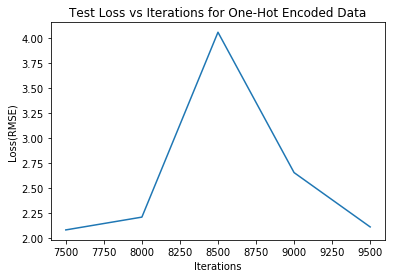

In [40]:
modelNums = [7500, 8000, 8500, 9000, 9500]
test_accuracy = []

for i in modelNums:
    test_accuracy.append(readAdamOptimized(test_data, test_minutes_labels, i))
print(test_accuracy)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_title('Test Loss vs Iterations for One-Hot Encoded Data')

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss(RMSE)')

ax.plot(modelNums, test_accuracy)

plt.savefig("paper/reluOneHotAdamTestData.png")
plt.show()

So, the testing data has a similar graph as the validation data did.  Due to time constraints I'm unable to explore into this further since it takes 10-12 hours to train these neural nets and quite frankly, the loss of this model is much better than the baseline; however, I would explore this behavior further by trying to create more training data (such as using March and April), use a different optimizer, create a 3-hidden layer neural network, change the number of neurons in the hidden layers as well as running for more iterations.

Out of curiousity, I want to see what this graph looks like for March data.

There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-7500
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-8000
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-8500
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-9000
There are 38 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_onehot\model.ckpnt-9500
[2.1334372, 2.2684145, 4.1818318, 2.8101845, 2.2369175]


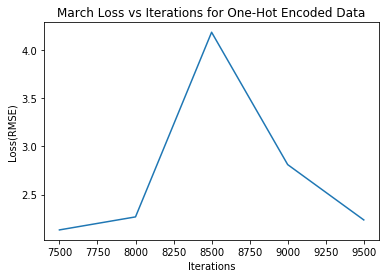

In [43]:
march_data, march_minutes_labels = oneHotEncodedData(march_data_load, getMinutes)

modelNums = [7500, 8000, 8500, 9000, 9500]
test_accuracy = []

for i in modelNums:
    test_accuracy.append(readAdamOptimized(march_data, march_minutes_labels, i))
print(test_accuracy)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_title('March Loss vs Iterations for One-Hot Encoded Data')

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss(RMSE)')

ax.plot(modelNums, test_accuracy)

plt.savefig("paper/reluOneHotAdamMarch.png")
plt.show()

So the March data (of which there is significantly more than the test dataset from the end of April) had a similar looking graph.  This really does point to me needing to spend some time figuring out what is going on as well as probably needing more training data and more iterations.

However, it is important to note that the RMSE loss for the March data is pretty good given the fact that I trained over April data!  So, this either means that the March data is similar to the April data, which is possible, or a model trained on one month could potentially be used for other months.  I had thought that this was possible which is why I had prepared the March data, but I was a bit surprised at how low the loss was for the March data.  This probably points to the model not necessarily overfitting the data since it did transfer to different month that had a lot of data; however, I would guess that more iterations or different layer/neuron setup might perform more optimally.  Furthermore, I wish that Tensorflow hadn't deleted the models for the earlier iterations so that I could see how it behaved in the beginning; I didn't realize until too late that it had deleted the earlier models.

But as I said, the loss here is significantly lower than that of the baseline, so I'm pretty happy!

One thing I have thought of is that every iteration, my algorithm trains along 300 random test samples.  If I do 9500 iterations, that means I have seen 2,850,000 test points, while my training dataset has a little over a million records.  I intentionally did this because I was using 300 random test samples every iteration and I wanted to ensure that many different combinations were seen.  It is possible that this is a problem; however, I would have expected to see that the taxi data blatantly overfit, but since the loss for March wasn't too bad, that does not seem to be the problem.  The batch size and iteration count are yet another parameter that could be tuned.  I tried to capture the model after every 500 iterations, but tensorflow only saved the last five.

### 

## Not One-Hot Encoded

Note that the below code corresponds to the function named reluGetWithRMSEMinutes in the NeuralNetCreateAndSave notebook.  

This neural net used GradientDescentOptimizer and only had 25 hidden neurons per layer because it was reading in the basic training data.

In [19]:
def reluGetWithRMSEMinutes(data, labels, modelNum = 9500):
    tf.reset_default_graph()
    
    #Only two layers
    batch_size = 300
    iterations = 9501
    
    inputFeatureSize = len(data[0])
    print("There are {} features".format(inputFeatureSize))
    hidden_units1 = 25
    hidden_units2 = 25
    output_size = 1
            
    input_placeholder = tf.placeholder(tf.float32, shape=(None, inputFeatureSize), name = "input_placeholder")
    labels_placeholder = tf.placeholder(tf.float32, shape=(None, 1), name = "labels_placeholder")
    
    #remember that we need W of small random values for gradient descent
    hiddenLayer1W = tf.get_variable("w1", shape = [inputFeatureSize, hidden_units1])
    hiddenLayer2W = tf.get_variable("w2", shape = [hidden_units1, hidden_units2])
    outW = tf.get_variable("outW", shape = [hidden_units2, output_size])

    hiddenLayer1b = tf.get_variable("b1", shape=[hidden_units1])
    hiddenLayer2b = tf.get_variable("b2", shape=[hidden_units2])
    outb = tf.get_variable("outB", shape=[output_size])

    hiddenLayer1 = tf.nn.relu(tf.matmul(input_placeholder, hiddenLayer1W) + hiddenLayer1b)
    hiddenLayer2 = tf.nn.relu(tf.matmul(hiddenLayer1, hiddenLayer2W) + hiddenLayer2b)
    p_out = tf.matmul(hiddenLayer2, outW) + outb
        
#     loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(tf.log(tf.add(p_out, tf.ones([len(p_out), 1]))), tf.log(tf.add(a_train, tf.ones([len(a_train), 1])))))))
    loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(labels_placeholder, p_out))))

    # Other optimizers - https://www.tensorflow.org/api_guides/python/train#Optimizers
    optimizer = tf.train.GradientDescentOptimizer(0.25)
    
    global_step_counter = tf.get_variable("globalStepVal", initializer = 0, trainable=False)
    train_op = optimizer.minimize(loss, global_step=global_step_counter)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        saver.restore(sess, "C:\\Users\\Brittany\\Dropbox\\School\\CMSC678\\machine-learning\\saved_models\\relu_RMSE_minutes\\model.ckpnt-{}".format(modelNum))
        
        # Calculate accuracy
        accuracy = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(labels_placeholder, p_out))))
        return accuracy.eval({input_placeholder: data, labels_placeholder: labels})

In [44]:
getMinutes = True
validation_data, v_minutes_labels = cleanData(validation_data_load, getMinutes)
test_data, test_minutes_labels = cleanData(validation_data_load, getMinutes)

In [45]:
modelNums = [7500, 8000, 8500, 9000, 9500]
validation_accuracy = []

for i in modelNums:
    validation_accuracy.append(reluGetWithRMSEMinutes(validation_data, v_minutes_labels, i))
print(validation_accuracy)

There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_RMSE_minutes\model.ckpnt-7500
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_RMSE_minutes\model.ckpnt-8000
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_RMSE_minutes\model.ckpnt-8500
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_RMSE_minutes\model.ckpnt-9000
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_RMSE_minutes\model.ckpnt-9500
[10.377611, 10.377223, 10.377613, 10.378854, 10.377358]


[10.377611, 10.377223, 10.377613, 10.378854, 10.377358]


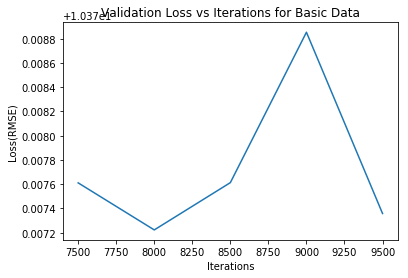

In [23]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_title('Validation Loss vs Iterations for Basic Data')

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss(RMSE)')

ax.plot(modelNums, validation_accuracy)

plt.savefig("paper/reluRMSE.png")
plt.show()

Note that at the top of the y axis it states that ~10 should be added to the axis, so loss is really 10+[value on y-axis].  Either way, we can see that the loss for the non-one-hot-encoded data is significantly worse than that of the previous model.  Unfortunately, I had changed a bit between the two models, like the data, the optimizer and the number of neurons in the 2 hidden layers, so it's difficult to pinpoint if the difference in loss is due to the the fact that the data is or is not one-hot encoded.  One of the big limitations of neural nets in my situation is that it took about 8-10 hours to train a neural net since I was on a personal laptop.

There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_RMSE_minutes\model.ckpnt-7500
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_RMSE_minutes\model.ckpnt-8000
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_RMSE_minutes\model.ckpnt-8500
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_RMSE_minutes\model.ckpnt-9000
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_RMSE_minutes\model.ckpnt-9500
[10.377611, 10.377223, 10.377613, 10.378854, 10.377358]


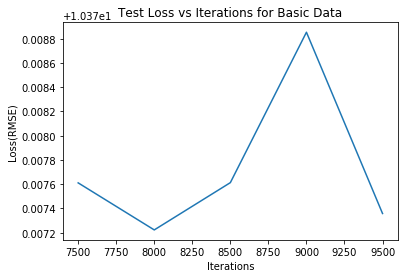

In [46]:
modelNums = [7500, 8000, 8500, 9000, 9500]
test_accuracy = []

for i in modelNums:
    test_accuracy.append(reluGetWithRMSEMinutes(test_data, test_minutes_labels, i))
print(test_accuracy)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_title('Test Loss vs Iterations for Basic Data')

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss(RMSE)')

ax.plot(modelNums, test_accuracy)

plt.savefig("paper/reluRMSETestData.png")
plt.show()

Once again, the loss on the test data is similar to the loss of the validation data.  This feature set also does the low loss to high loss to low loss behavior that the previous model exhibited as well.

## RMSLE (The Kaggle Competition)

Since this project originally was insprired by the Kaggle competition, I did decide to train a neural net that could have potentially been used in the competition.  This isn't a good "apples to apples" comparison because I did not use the Kaggle data and their data might have been a bit messier or spanned more days; however, the RMSLE loss I calculated was on par with that of the top ranked models.  In fact, my lowest test loss was 0.29184, while the lowest loss on the leaderboard is 0.28976, with second place going to a model which achieved 0.30664. 

Note that I did not use the one-hot encoded data which produced better results for the RMSE loss optimization done above.  This was actually one of my first attempts at building a neural net before I decided to focus on the RMSE loss; however, the results were strong enough that I thought it would be worth mentioning.

In [47]:
def buildNeuralNetRMSLE(data, labels, modelNum = 9500):
    tf.reset_default_graph()
    
    #Only two layers
    batch_size = 300
    iterations = 10000
    
    inputFeatureSize = len(data[0])
    print("There are {} features".format(inputFeatureSize))
    hidden_units1 = 25
    hidden_units2 = 25
    output_size = 1
            
    input_placeholder = tf.placeholder(tf.float32, shape=(None, inputFeatureSize), name = "input_placeholder")
    labels_placeholder = tf.placeholder(tf.float32, shape=(None, 1), name = "labels_placeholder")
    
    #remember that we need W of small random values for gradient descent
    hiddenLayer1W = tf.get_variable("w1", initializer = tf.truncated_normal([inputFeatureSize, hidden_units1], stddev=1.0 / math.sqrt(float(inputFeatureSize))))
    hiddenLayer2W = tf.get_variable("w2", initializer = tf.truncated_normal(shape=(hidden_units1, hidden_units2), stddev=1.0 / math.sqrt(float(inputFeatureSize))))
    outW = tf.get_variable("outW", initializer = tf.truncated_normal(shape=(hidden_units2, output_size), stddev=1.0 / math.sqrt(float(inputFeatureSize))))

    hiddenLayer1b = tf.get_variable("b1", initializer = tf.truncated_normal([hidden_units1], stddev=1.0 / math.sqrt(float(inputFeatureSize))))
    hiddenLayer2b = tf.get_variable("b2", initializer = tf.truncated_normal([hidden_units2], stddev=1.0 / math.sqrt(float(inputFeatureSize))))
    outb = tf.get_variable("outB", initializer = tf.truncated_normal([output_size], stddev=1.0 / math.sqrt(float(inputFeatureSize))))

    hiddenLayer1 = tf.nn.relu(tf.matmul(input_placeholder, hiddenLayer1W) + hiddenLayer1b)
    hiddenLayer2 = tf.nn.relu(tf.matmul(hiddenLayer1, hiddenLayer2W) + hiddenLayer2b)
    p_out = tf.matmul(hiddenLayer2, outW) + outb
        
#     loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(tf.log(tf.add(p_out, tf.ones([len(p_out), 1]))), tf.log(tf.add(a_train, tf.ones([len(a_train), 1])))))))
    loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(tf.log(tf.add(p_out, tf.ones(tf.stack([tf.shape(p_out)[0], 1])))), tf.log(tf.add(labels_placeholder, tf.ones(tf.stack([tf.shape(labels_placeholder)[0], 1]))))))))

    # Other optimizers - https://www.tensorflow.org/api_guides/python/train#Optimizers
    optimizer = tf.train.GradientDescentOptimizer(0.25)
    
    global_step_counter = tf.get_variable("globalStepVal", initializer = 0, trainable=False)
    train_op = optimizer.minimize(loss, global_step=global_step_counter)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        saver.restore(sess, "C:\\Users\\Brittany\\Dropbox\\School\\CMSC678\\machine-learning\\saved_models\\relu_final\\model.ckpnt-{}".format(modelNum))
                
        # Calculate accuracy
        accuracy = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(tf.log(tf.add(p_out, tf.ones(tf.stack([tf.shape(p_out)[0], 1])))), tf.log(tf.add(labels_placeholder, tf.ones(tf.stack([tf.shape(labels_placeholder)[0], 1]))))))))
        return accuracy.eval({input_placeholder: data, labels_placeholder: labels})

v_minutes_labels and test_minutes_labels are really the seconds!

In [48]:
getMinutes = False
validation_data, v_minutes_labels = cleanData(validation_data_load, getMinutes)
test_data, test_minutes_labels = cleanData(validation_data_load, getMinutes)

There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_final\model.ckpnt-7500
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_final\model.ckpnt-8000
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_final\model.ckpnt-8500
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_final\model.ckpnt-9000
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_final\model.ckpnt-9500
[0.3947216, 0.29184124, 0.32354066, 0.34826654, 0.31530285]


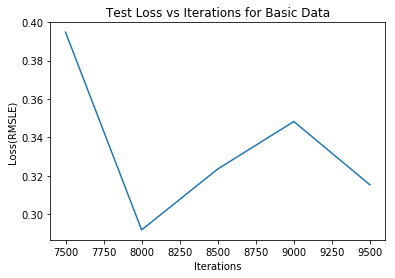

In [49]:
modelNums = [7500, 8000, 8500, 9000, 9500]
test_accuracy = []

for i in modelNums:
    test_accuracy.append(buildNeuralNetRMSLE(test_data, test_minutes_labels, i))
print(test_accuracy)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_title('Test Loss vs Iterations for Basic Data')

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss(RMSLE)')

ax.plot(modelNums, test_accuracy)

plt.savefig("paper/reluRMSLETestData.png")
plt.show()

There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_final\model.ckpnt-7500
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_final\model.ckpnt-8000
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_final\model.ckpnt-8500
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_final\model.ckpnt-9000
There are 25 features
INFO:tensorflow:Restoring parameters from C:\Users\Brittany\Dropbox\School\CMSC678\machine-learning\saved_models\relu_final\model.ckpnt-9500
[0.40078557, 0.28875709, 0.3160497, 0.34919327, 0.31798878]


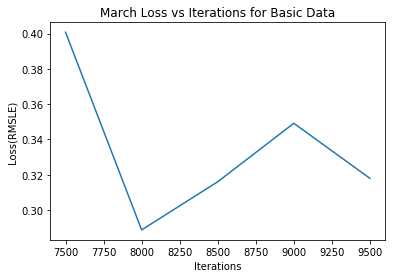

In [50]:
march_data, march_minutes_labels = cleanData(march_data_load, getMinutes)

modelNums = [7500, 8000, 8500, 9000, 9500]
test_accuracy = []

for i in modelNums:
    test_accuracy.append(buildNeuralNetRMSLE(march_data, march_minutes_labels, i))
print(test_accuracy)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_title('March Loss vs Iterations for Basic Data')

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss(RMSLE)')

ax.plot(modelNums, test_accuracy)

plt.savefig("paper/reluRMSLETestDataMarch.png")
plt.show()

Once again, we see the model fall into a local minima and then come again.  This might be for the same reasons discussed above.